### Import libaries for data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read files

In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Join tables

In [5]:
movie_ratings = pd.merge(ratings, movies, on="movieId")
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Add rating class

In [6]:
rating_classes = ['bad', 'good']

def assign_rating_class(x):
    if x.rating < 4:
        return 'bad'
    return 'good'

movie_ratings["rating_class"] = movie_ratings.apply(lambda x: assign_rating_class(x), axis=1)
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres,rating_class
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,bad
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,good


(0.0, 5.5)

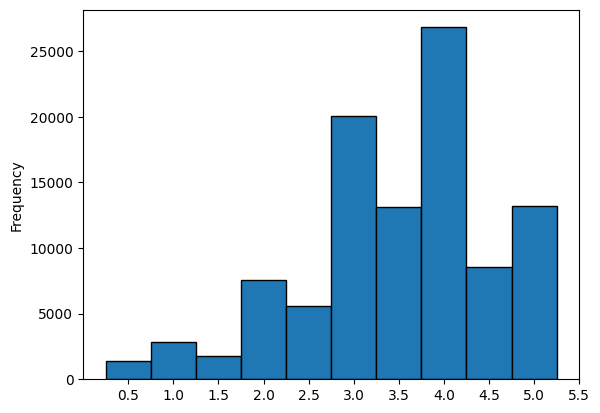

In [7]:
bins = np.arange(0.5, 6, 0.5) - 0.25
movie_ratings.rating.plot(kind='hist', edgecolor="black", bins=bins)
plt.xticks(np.arange(0.5, 6, 0.5))
plt.xlim([0, 5.5])

### Take year intervals

Sum of excluded movies: 13
Min year: 1902
Max year: 2018


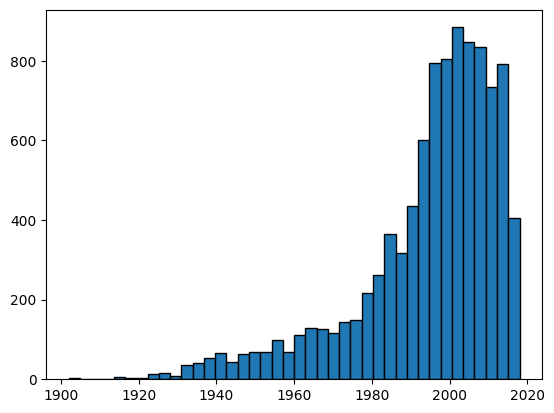

In [8]:
import re

# extract years
movie_years = movies.title.str.strip().apply(lambda x: re.findall(r'\(\d+\)$', x)).str[0].str[1:-1]
# remove titles with no year and display their count
movie_mask = [0 if x == x else 1 for x in movie_years]
removed_films = sum(movie_mask)
movie_years = [int(movie_years[x]) for x in range(len(movie_years)) if movie_mask[x] == 0]

print(f'Sum of excluded movies: {removed_films}')
print(f"Min year: {min(movie_years)}")
print(f"Max year: {max(movie_years)}")

plt.hist(movie_years, bins=40, edgecolor="black")
plt.show()

In [9]:
# year_intervals_5 = [f"[{str(x)},{str(x+5)}]" for x in range(1920, 2020, 5)]
year_intervals_10 = [f"({str(x)},{str(x+10)}]" for x in range(1920, 2020, 10)]
year_intervals_10

['(1920,1930]',
 '(1930,1940]',
 '(1940,1950]',
 '(1950,1960]',
 '(1960,1970]',
 '(1970,1980]',
 '(1980,1990]',
 '(1990,2000]',
 '(2000,2010]',
 '(2010,2020]']

### Create table of users to film rating and year interval

In [10]:
year_ratings = [str(year) + "|" + rating for year in year_intervals_10 for rating in rating_classes]
year_ratings[:5]

['(1920,1930]|bad',
 '(1920,1930]|good',
 '(1930,1940]|bad',
 '(1930,1940]|good',
 '(1940,1950]|bad']

### Binarize the data

In [11]:
def get_year_interval(year):
    # if nan
    try:
        year = int(year)
    except ValueError:
        return ""
    
    for x in range(1920, 2020, 10):
        if (year <= x+10 and year > x):
            return f"({str(x)},{str(x+10)}]"
    
    # if not a year in the interval
    return ""

unique_users = ratings.userId.unique()

binary_df = np.zeros((len(unique_users), len(year_ratings)), dtype=np.int8)

for user_id in unique_users:
    user_ratings = movie_ratings.loc[movie_ratings['userId'] == user_id]
    user_movie_years = user_ratings.title.str.strip().apply(lambda x: re.findall(r'\(\d+\)$', x)).str[0].str[1:-1]
    user_movie_ratings = user_ratings.rating_class
    user_movie_year_ratings = set([get_year_interval(year) + "|" + r_class for year, r_class in zip(user_movie_years, user_movie_ratings)])
    binary_df[user_id-1] = [1 if x in user_movie_year_ratings else 0 for x in year_ratings]

In [12]:
binary_df = pd.DataFrame(binary_df)
binary_df.columns = year_ratings
binary_df = binary_df.astype(bool)
binary_df_users = binary_df.copy()
binary_df_users.insert(0, column="userId", value=unique_users)
binary_df_users.tail(5)

,userId,"(1920,1930]|bad","(1920,1930]|good","(1930,1940]|bad","(1930,1940]|good","(1940,1950]|bad","(1940,1950]|good","(1950,1960]|bad","(1950,1960]|good","(1960,1970]|bad",...,"(1970,1980]|bad","(1970,1980]|good","(1980,1990]|bad","(1980,1990]|good","(1990,2000]|bad","(1990,2000]|good","(2000,2010]|bad","(2000,2010]|good","(2010,2020]|bad","(2010,2020]|good"
605,606,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
606,607,False,False,True,True,False,True,True,True,True,...,True,True,True,True,True,True,True,False,False,False
607,608,False,False,True,False,True,False,True,False,True,...,True,True,True,True,True,True,True,True,False,False
608,609,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,False,False,False,False
609,610,False,False,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


### Run apriori algorithm

In [13]:
from mlxtend.frequent_patterns import apriori

In [14]:
frequent_itemsets = apriori(binary_df, min_support=0.4, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.473770,"((1960,1970]|good)"
1,0.552459,"((1970,1980]|bad)"
2,0.695082,"((1970,1980]|good)"
3,0.788525,"((1980,1990]|bad)"
4,0.836066,"((1980,1990]|good)"
...,...,...
170,0.480328,"((2000,2010]|good, (1990,2000]|bad, (2000,2010..."
171,0.432787,"((1990,2000]|bad, (1970,1980]|good, (1970,1980..."
172,0.400000,"((2000,2010]|good, (1990,2000]|bad, (1970,1980..."
173,0.413115,"((2000,2010]|good, (1990,2000]|bad, (2000,2010..."


### Find association rules

In [15]:
from mlxtend.frequent_patterns import association_rules

In [16]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"((1960,1970]|good)","((1970,1980]|good)",0.473770,0.695082,0.431148,0.910035,1.309248,0.101838,3.389281,0.448859
1,"((1960,1970]|good)","((1980,1990]|bad)",0.473770,0.788525,0.434426,0.916955,1.162874,0.060847,2.546516,0.266161
2,"((1960,1970]|good)","((1980,1990]|good)",0.473770,0.836066,0.454098,0.958478,1.146414,0.057995,3.948087,0.242698
3,"((1960,1970]|good)","((1990,2000]|bad)",0.473770,0.960656,0.472131,0.996540,1.037354,0.017001,11.370492,0.068428
4,"((1960,1970]|good)","((1990,2000]|good)",0.473770,0.986885,0.468852,0.989619,1.002770,0.001295,1.263388,0.005250
...,...,...,...,...,...,...,...,...,...,...
934,"((1980,1990]|good, (2000,2010]|bad, (1990,2000...","((1980,1990]|bad, (2000,2010]|good, (1990,2000...",0.509836,0.503279,0.419672,0.823151,1.635577,0.163083,2.808733,0.792786
935,"((1980,1990]|bad, (1980,1990]|good, (2000,2010...","((2000,2010]|good, (1990,2000]|bad, (1990,2000...",0.440984,0.591803,0.419672,0.951673,1.608090,0.158697,8.446532,0.676446
936,"((1980,1990]|bad, (2000,2010]|good)","((1990,2000]|bad, (1980,1990]|good, (2000,2010...",0.514754,0.493443,0.419672,0.815287,1.652242,0.165671,2.742397,0.813529
937,"((1980,1990]|bad, (2000,2010]|bad)","((2000,2010]|good, (1990,2000]|bad, (1980,1990...",0.486885,0.527869,0.419672,0.861953,1.632892,0.162661,3.420072,0.755366


#### Write results to files

In [17]:
with open("frequent_itemsets.txt", "w") as fi:
    fi.write(frequent_itemsets.to_string())

In [30]:
with open("association_rules.txt", "w") as fr:
    fr.write(rules.to_string())

In [65]:
with open("association_rules.txt", "w") as fr:
    for row in rules.iterrows():
        fr.write(row[1].to_string())
        fr.write("\n=========================================\n")